# Kerala (India) Floods in 2018

* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton University

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['hatch.color']='g'
import xarray as xr
import pandas as pd
import datetime
import skextremes as ske

import geoxarray
from geoplots import mapplot, xticks2month

%matplotlib notebook

In [2]:
# parameters
box = dict(lon=(74,77), lat=(9,12))
box2 = dict(lon=(74,78), lat=(9,13))
clim_span = ('1981', '2010')

days_per_month = xr.DataArray([31,29,31,30,31,30,31,31,30,31,30,31], dims=['month'], coords=[range(1,13)])

pr_scale = 24*3600
prect_scale = 24*3600*1000


def eprob(da, **kws):
    '''Exceedance Probability estimation given sample da'''
    h, b = np.histogram(da, **kws)
    csum = np.cumsum(h)
    eprob = 1- csum[:-1]/csum[-1]
    return xr.DataArray(eprob, dims='b', coords=[b[1:-1],])

# data das
if 'das' in locals() or 'das' in globals():
    print(das.keys())
else:
    das = dict()

In [3]:
# data obs
# gpcc
da = xr.open_dataarray('gpcc.nc') \
    .groupby('time.month')/days_per_month # mm/month -> mm/day
das['gpcc'] = da.copy()

lonc = das['gpcc'].lon
latc = das['gpcc'].lat[-1::-1]
landmaskc = das['gpcc'].mean('time') \
    .pipe(lambda x: x*0) \
    .pipe(lambda x: x.where(x>=0, other=-1)+1)

# # chirps
# da = xr.open_dataarray('chirps.monthly.EA.nc').load().rename(dict(longitude='lon', latitude='lat')) \
#     .groupby('time.month')/days_per_month # mm/month -> mm/day
# das['chirps'] = da.copy()

# # topo
# das['topo'] = xr.open_dataarray('topo.nc')

In [4]:
# data FLOR
new_dims = dict(grid_xt='lon', grid_yt='lat')
# 1860
with xr.set_options(enable_cftimeindex=True):
    da = xr.open_dataset('CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_daily.precip.nc').precip.rename(new_dims)
da = da * pr_scale
das['flor_1860'] = da.copy()

# 2000
with xr.set_options(enable_cftimeindex=True):
    da = xr.open_dataset('CTL2000_noleap_tigercpu_intelmpi_18_576PE.atmos_daily.precip.nc').precip.rename(new_dims)
da = da * pr_scale
das['flor_2000'] = da.copy()

In [6]:
# data CESM1.2.1
# 1850
with xr.set_options(enable_cftimeindex=True):
    da = xr.open_dataset('B1850CN_f05g16_tigercpu_intelmpi18_512PE.cam.h1.PRECT.nc').PRECT
da = da * prect_scale
das['florish_1850'] = da.copy()

# 2000
with xr.set_options(enable_cftimeindex=True):
    da = xr.open_dataset('BCN_f05g16_tigercpu_intelmpi18_512PE.cam.h1.PRECT.nc').PRECT
da = da * prect_scale
das['florish_2000'] = da.copy()

# # landmask
# da = xr.open_dataset('cesm1_2_1.f05g16.SST.nc').SST.mean('time') \
#     .pipe(lambda x: x.where(x==0, other=-1) + 1)
# das['landmask.cesm1.2.1.f05g16'] = da

In [7]:
# data CESM2.0
# 1850
with xr.set_options(enable_cftimeindex=True):
    da = xr.open_dataset('b.e20.B1850.f09_g17.tigercpu_intelmpi_18_540PE.cam.h1.PRECT.nc').PRECT
da = da * prect_scale
das['cesm2_1850'] = da.copy()


# # landmask
# da = xr.open_dataset('cesm2.f09g17.SST.nc').SST.mean('time') \
#     .pipe(lambda x: x.where(x==0, other=-1) + 1)
# das['landmask.cesm2.f09g17'] = da

## Climatology

### GPCC

In [213]:
# data: gpcc
da = das['gpcc'].sel(time=slice(*clim_span)).groupby('time.month').mean('time')

<IPython.core.display.Javascript object>


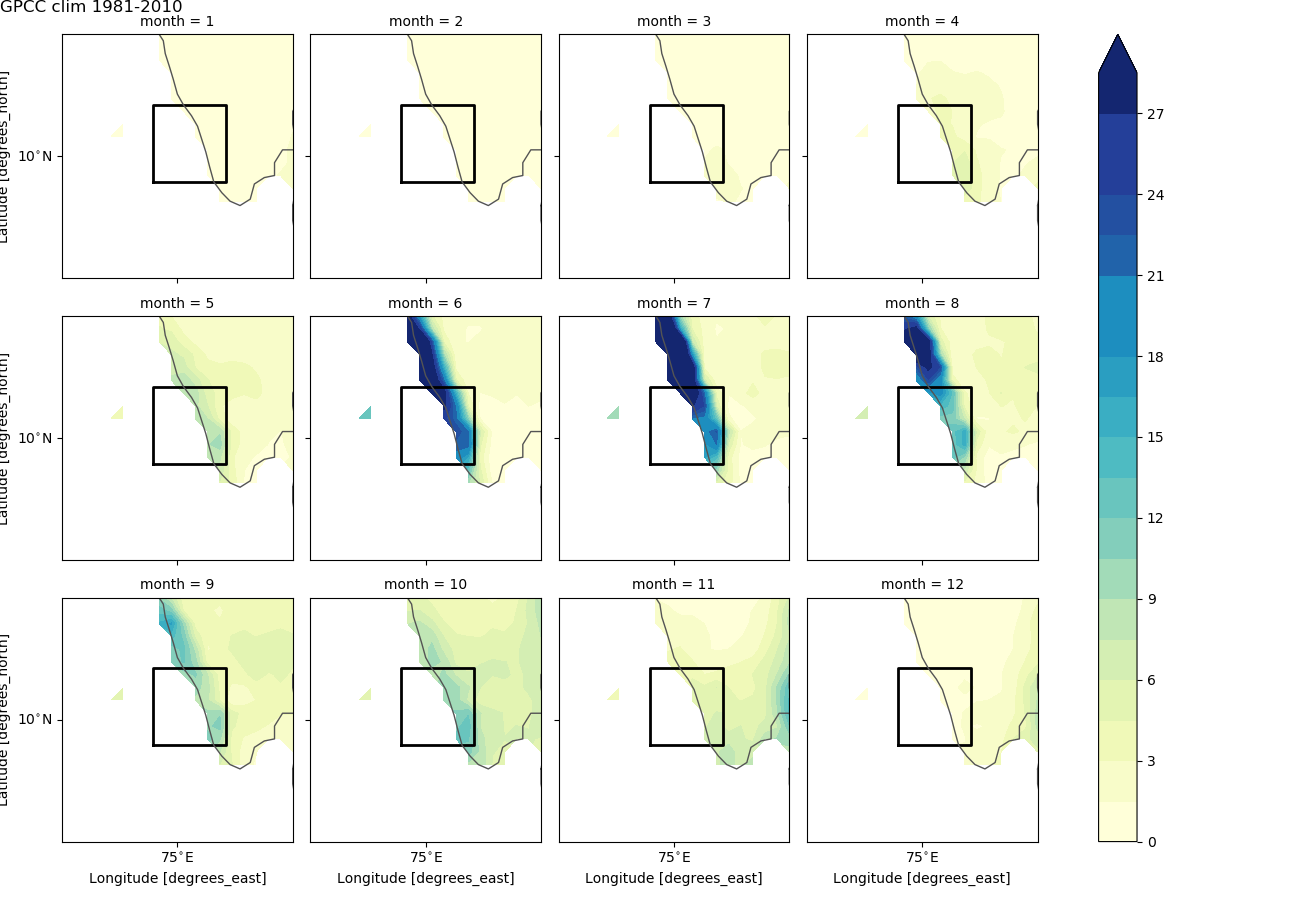

In [214]:
# plot: gpcc
xticks = range(70,80+1,5)
yticks = range(5,15+1,5)
f = da.plot.contourf(col='month', col_wrap=4, cmap='YlGnBu', levels=20, robust=True)
for ii,ax in enumerate(f.axes.flat):
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=box['lon']+box['lat'], ax=ax)
plt.suptitle('GPCC clim 1981-2010', x=0, y=1, ha='left', va='top')

plt.savefig('figs/clim.gpcc.pdf')

### FLOR

<IPython.core.display.Javascript object>


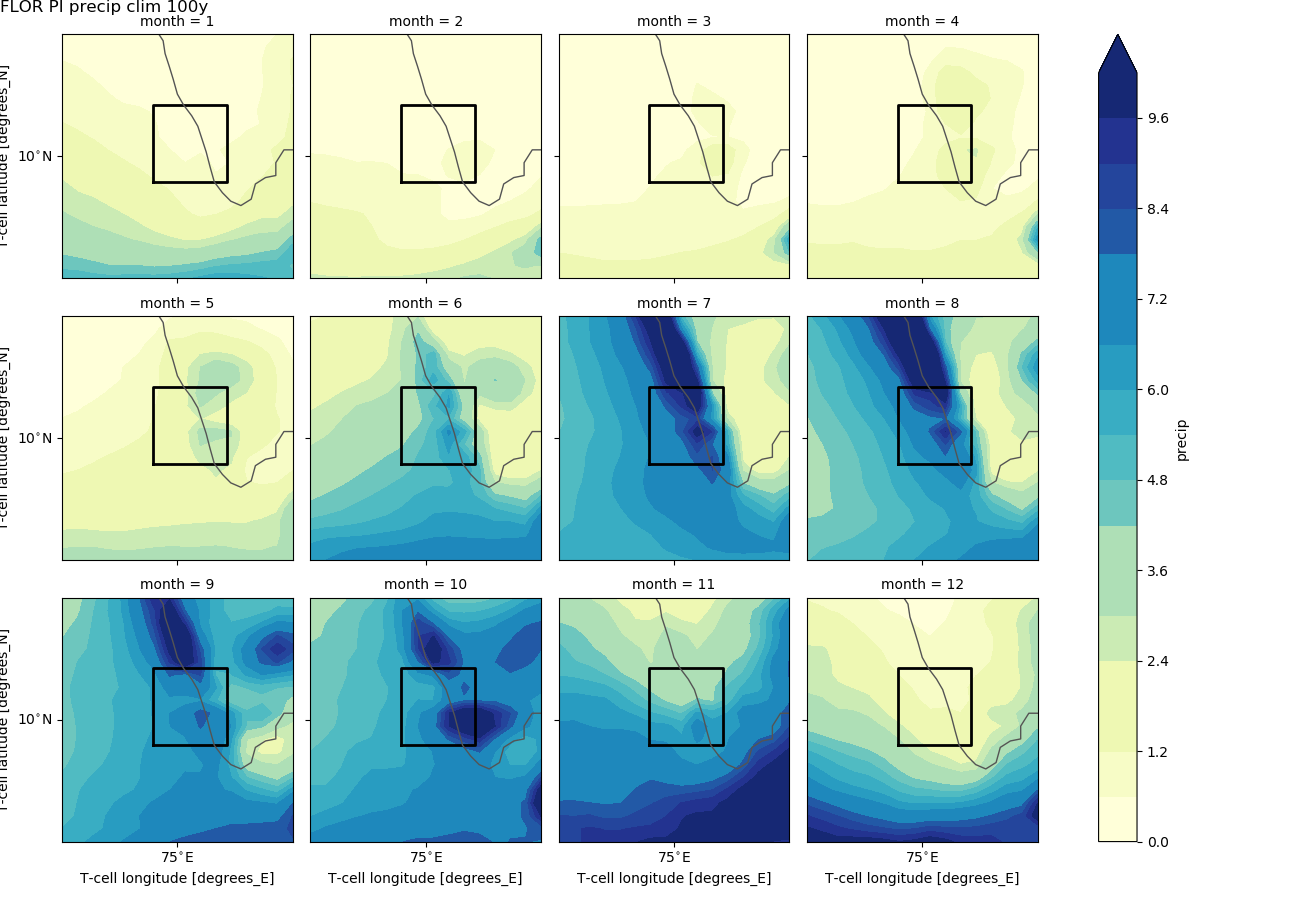

In [220]:
# plot: flor 1860
year_span = ('0101', '0200')
da = das['flor_1860'].sel(time=slice(*year_span)).groupby('time.month').mean('time')
xticks = range(70,80+1,5)
yticks = range(5,15+1,5)

f = da.plot.contourf(col='month', col_wrap=4, cmap='YlGnBu', levels=20, robust=True)
for ii,ax in enumerate(f.axes.flat):
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=box['lon']+box['lat'],ax=ax)
plt.suptitle('FLOR PI precip clim 100y', x=0, y=1, ha='left', va='top')

plt.savefig('figs/clim.1860.flor.pdf')

<IPython.core.display.Javascript object>


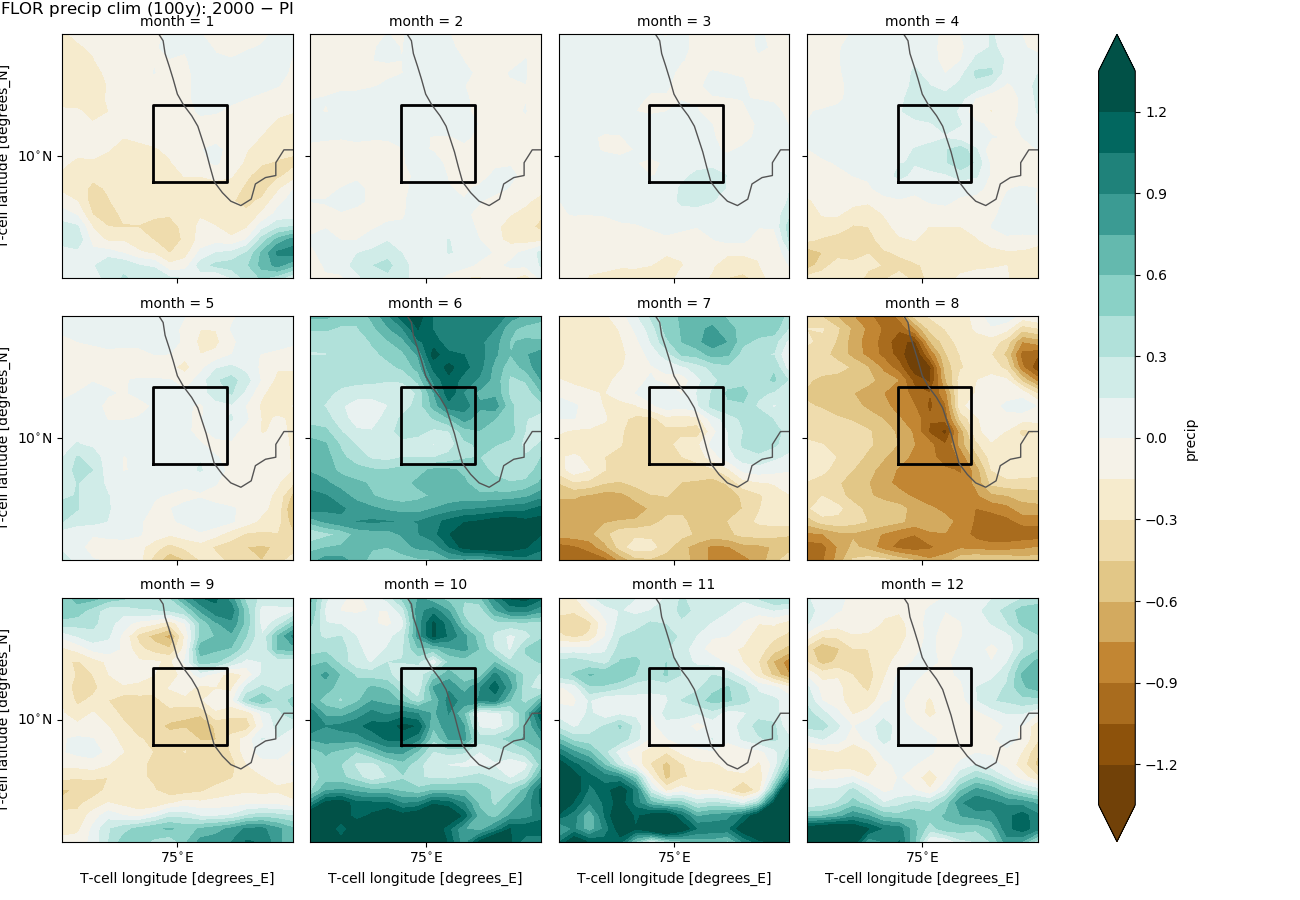

In [221]:
# plot
da = das['flor_2000'].sel(time=slice(*year_span)).groupby('time.month').mean('time') \
    - das['flor_1860'].sel(time=slice(*year_span)).groupby('time.month').mean('time')
xticks = range(70,80+1,5)
yticks = range(5,15+1,5)

f = da.plot.contourf(col='month', col_wrap=4, cmap='BrBG', levels=20, robust=True)
for ii,ax in enumerate(f.axes.flat):
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=box['lon']+box['lat'], ax=ax)
plt.suptitle('FLOR precip clim (100y): 2000 $-$ PI', x=0, y=1, ha='left', va='top')

plt.savefig('figs/clim_diff.2000-1860.flor.pdf')

### FLORish

<IPython.core.display.Javascript object>


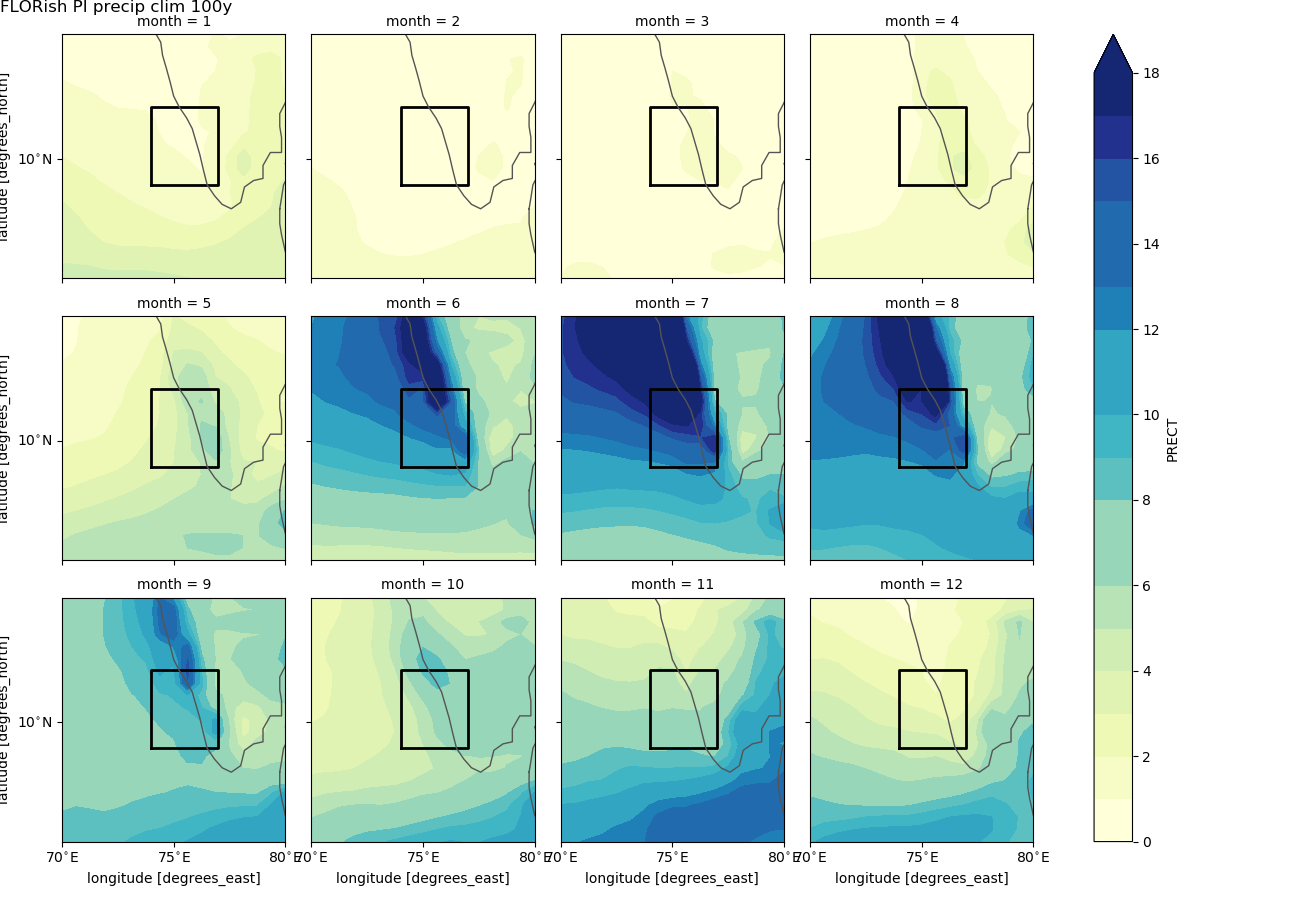

In [222]:
# plot: florish 1850
year_span = ('0101', '0200')
da = das['florish_1850'].sel(time=slice(*year_span)).groupby('time.month').mean('time')
xticks = range(70,80+1,5)
yticks = range(5,15+1,5)

f = da.plot.contourf(col='month', col_wrap=4, cmap='YlGnBu', levels=20, robust=True)
for ii,ax in enumerate(f.axes.flat):
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=box['lon']+box['lat'],ax=ax)
plt.suptitle('FLORish PI precip clim 100y', x=0, y=1, ha='left', va='top')

plt.savefig('figs/clim.1850.florish.pdf')

<IPython.core.display.Javascript object>


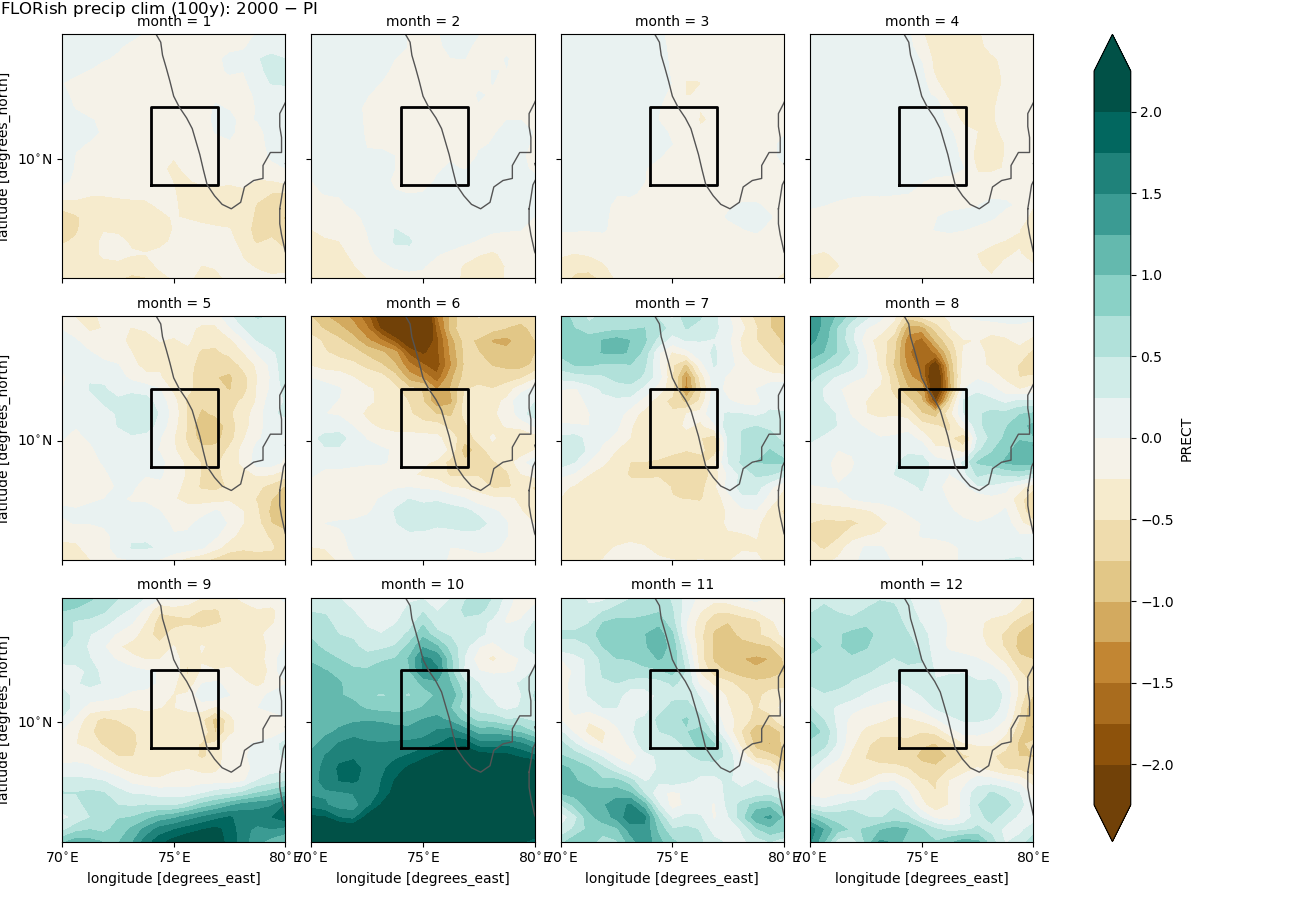

In [219]:
# plot
da = das['florish_2000'].sel(time=slice(*year_span)).groupby('time.month').mean('time') \
    - das['florish_1850'].sel(time=slice(*year_span)).groupby('time.month').mean('time')
xticks = range(70,80+1,5)
yticks = range(5,15+1,5)

f = da.plot.contourf(col='month', col_wrap=4, cmap='BrBG', levels=20, robust=True)
for ii,ax in enumerate(f.axes.flat):
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=box['lon']+box['lat'], ax=ax)
plt.suptitle('FLORish precip clim (100y): 2000 $-$ PI', x=0, y=1, ha='left', va='top')

plt.savefig('figs/clim_diff.2000-1850.florish.pdf')

### CESM2.0

<IPython.core.display.Javascript object>


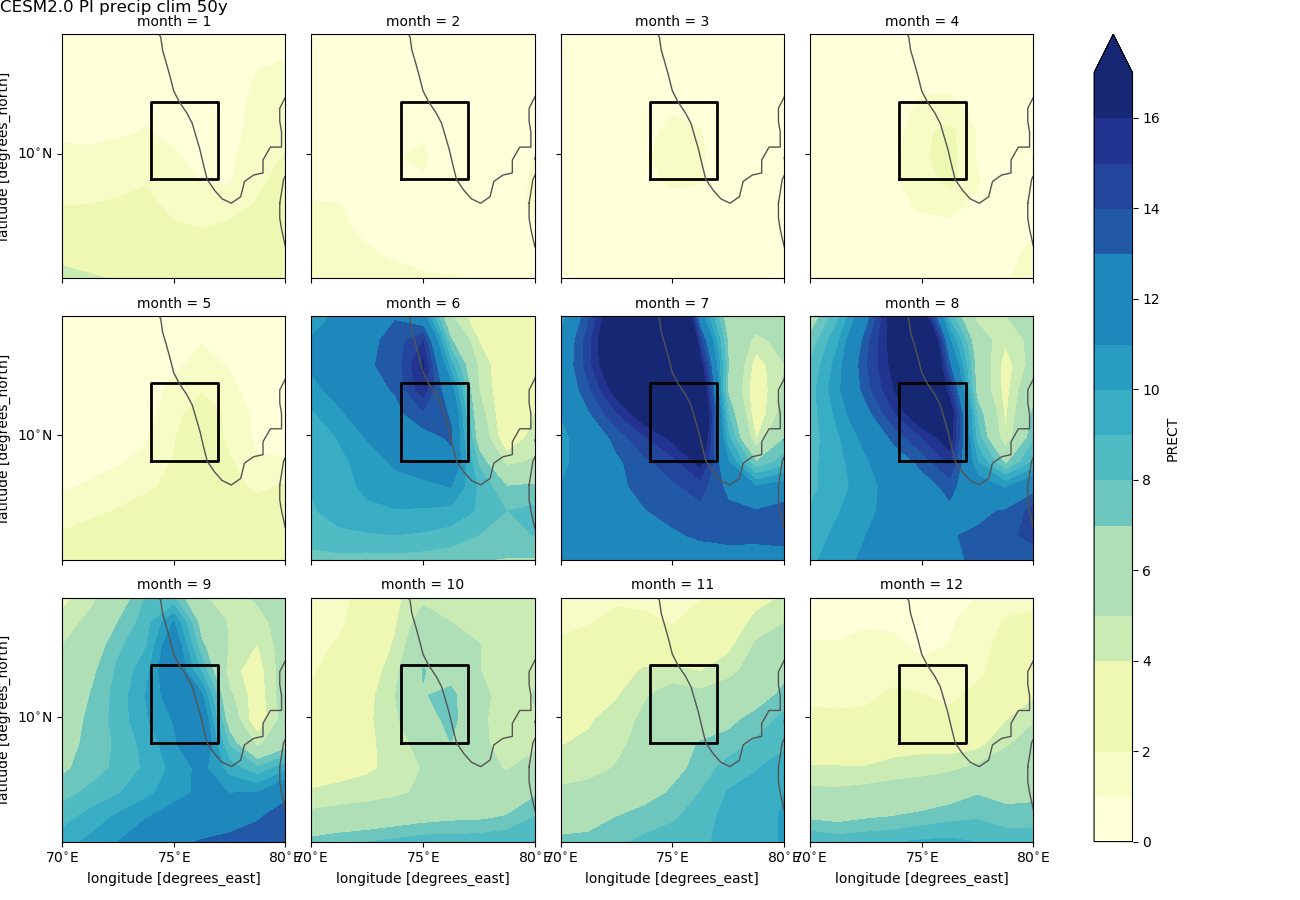

In [223]:
# plot: florish 1850
year_span = ('0101', '0150')
da = das['cesm2_1850'].sel(time=slice(*year_span)).groupby('time.month').mean('time')
xticks = range(70,80+1,5)
yticks = range(5,15+1,5)

f = da.plot.contourf(col='month', col_wrap=4, cmap='YlGnBu', levels=20, robust=True)
for ii,ax in enumerate(f.axes.flat):
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=box['lon']+box['lat'],ax=ax)
plt.suptitle('CESM2.0 PI precip clim 50y', x=0, y=1, ha='left', va='top')

plt.savefig('figs/clim.1850.cesm2.pdf')

## Seasonal cycle

<IPython.core.display.Javascript object>


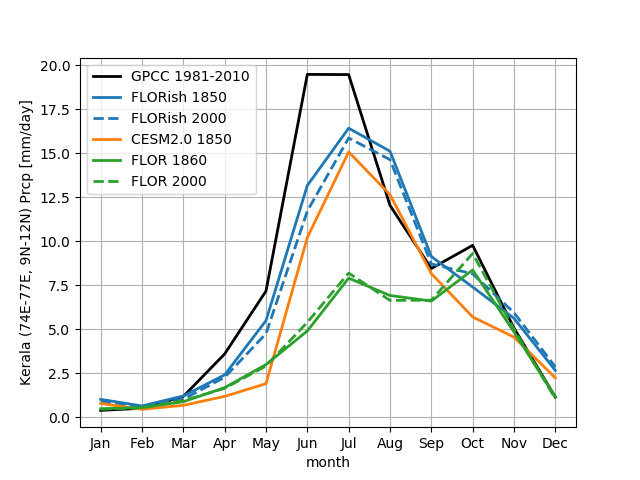

In [224]:
# plot: seasonal cycle
lon = das['gpcc'].lon
lat = das['gpcc'].lat[-1::-1]
landmask = das['gpcc'].mean('time') \
    .pipe(lambda x: x*0) \
    .pipe(lambda x: x.where(x>=0, other=-1)+1)

das['gpcc'].sel(time=slice(*clim_span)).groupby('time.month').mean('time') \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'][-1::-1])).geo.fldmean() \
    .plot(label=f'GPCC {clim_span[0]}-{clim_span[1]}', color='k')
das['florish_1850'].groupby('time.month').mean('time') \
    .interp(lon=lon, lat=lat) \
    .where(landmask>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])) \
    .geo.fldmean() \
    .plot(label='FLORish 1850', color='C0')
das['florish_2000'].groupby('time.month').mean('time') \
    .interp(lon=lon, lat=lat) \
    .where(landmask>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])) \
    .geo.fldmean() \
    .plot(label='FLORish 2000', color='C0', ls='--')
das['cesm2_1850'].groupby('time.month').mean('time') \
    .interp(lon=lon, lat=lat) \
    .where(landmask>.5) \
    .sel(lon=slice(*box2['lon']), lat=slice(*box2['lat'])) \
    .geo.fldmean() \
    .plot(label='CESM2.0 1850', color='C1')
das['flor_1860'].groupby('time.month').mean('time') \
    .interp(lon=lon, lat=lat) \
    .where(landmask>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])) \
    .geo.fldmean() \
    .plot(label='FLOR 1860', color='C2')
das['flor_2000'].groupby('time.month').mean('time') \
    .interp(lon=lon, lat=lat) \
    .where(landmask>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])) \
    .geo.fldmean() \
    .plot(label='FLOR 2000', color='C2', ls='--')

xticks2month(range(1,13))
plt.legend(frameon=True)
plt.grid(True)
lon0,lon1 = box['lon']
lat0,lat1 = box['lat']
plt.ylabel(f'Kerala ({lon0}E-{lon1}E, {lat0}N-{lat1}N) Prcp [mm/day]')

plt.savefig('figs/cycle.pdf')

## Series

JJA

<IPython.core.display.Javascript object>


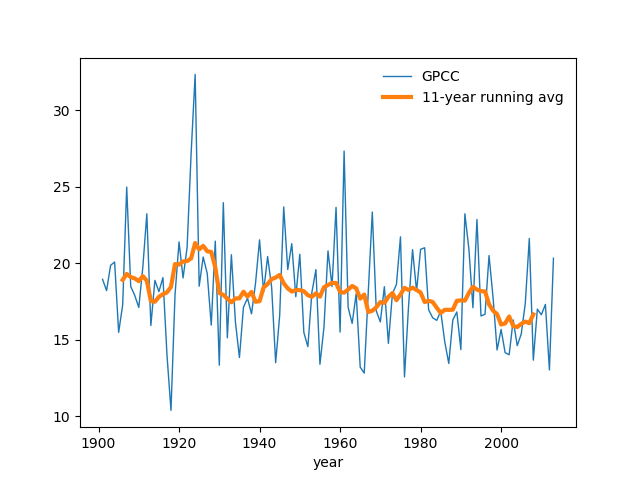

In [10]:
# 
da = das['gpcc'] \
    .pipe(lambda da: da[(da['time.month']>=6)&(da['time.month']<=8)]) \
    .groupby('time.year').mean('time')\
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'][-1::-1])).geo.fldmean()
da.plot(label=f'GPCC', lw=1)
da.rolling(year=11, center=True).mean().plot(label='11-year running avg', lw=3)

plt.legend()
plt.savefig('figs/series.gpcc.pdf')

JJAS

<IPython.core.display.Javascript object>


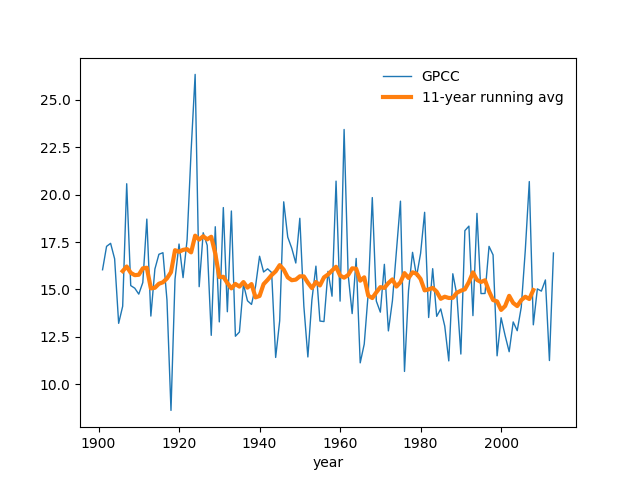

In [9]:
# 
da = das['gpcc'] \
    .pipe(lambda da: da[(da['time.month']>=6)&(da['time.month']<=9)]) \
    .groupby('time.year').mean('time')\
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'][-1::-1])).geo.fldmean()
da.plot(label=f'GPCC', lw=1)
da.rolling(year=11, center=True).mean().plot(label='11-year running avg', lw=3)

plt.legend()
plt.savefig('figs/series.gpcc.jjas.pdf')

Take into account the number of days in each month when calculating the seasonal mean

<IPython.core.display.Javascript object>


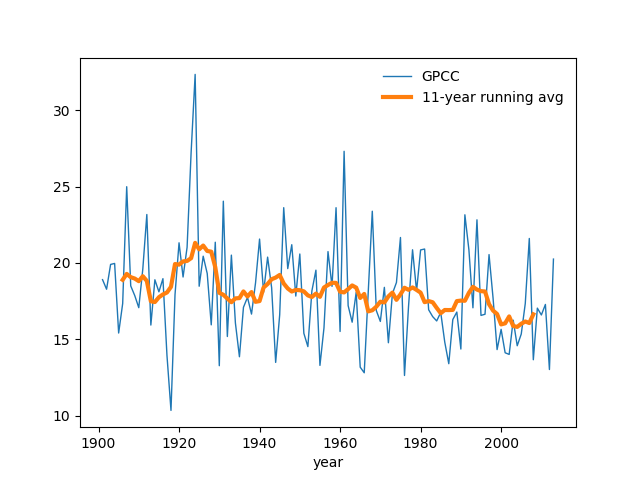

In [149]:
# more accurate
da = ( das['gpcc'].groupby('time.month') * days_per_month ) \
    .pipe(lambda da: da[(da['time.month']>=6)&(da['time.month']<=8)]) \
    .groupby('time.year').sum('time', skipna=False).pipe(lambda da: da/92.0) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'][-1::-1])).geo.fldmean()
da.plot(label=f'GPCC', lw=1)
da.rolling(year=11, center=True).mean().plot(label='11-year running avg', lw=3)

plt.legend()

## Accumulation 

### FLOR

JJA

<IPython.core.display.Javascript object>


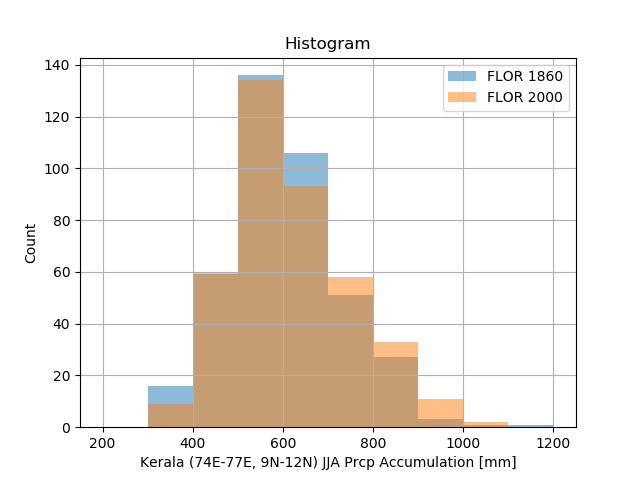

In [226]:
# plot
lon = das['gpcc'].lon
lat = das['gpcc'].lat[-1::-1]
landmask = das['gpcc'].mean('time') \
    .pipe(lambda x: x*0) \
    .pipe(lambda x: x.where(x>=0, other=-1)+1)
bins = range(200,1200+1,100)
year_span = ('0001', '0400')

# 1850
da = das['flor_1860'].sel(time=slice(*year_span)) \
    .interp(lon=lon, lat=lat).where(landmask>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=8)]) \
    .groupby('time.year').sum('time')
da.plot.hist(label='FLOR 1860', alpha=.5, bins=bins)

# 2000
da = das['flor_2000'].sel(time=slice(*year_span)) \
    .interp(lon=lon, lat=lat).where(landmask>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=8)]) \
    .groupby('time.year').sum('time')
da.plot.hist(label='FLOR 2000', alpha=.5, bins=bins)
plt.grid(True)
plt.legend(frameon=True)
(lonmin,lonmax), (latmin,latmax) = box['lon'], box['lat']
plt.xlabel(f'Kerala ({lonmin}E-{lonmax}E, {latmin}N-{latmax}N) JJA Prcp Accumulation [mm]')

plt.savefig('figs/hist.JJAaccum.flor.pdf')

JJAS

<IPython.core.display.Javascript object>


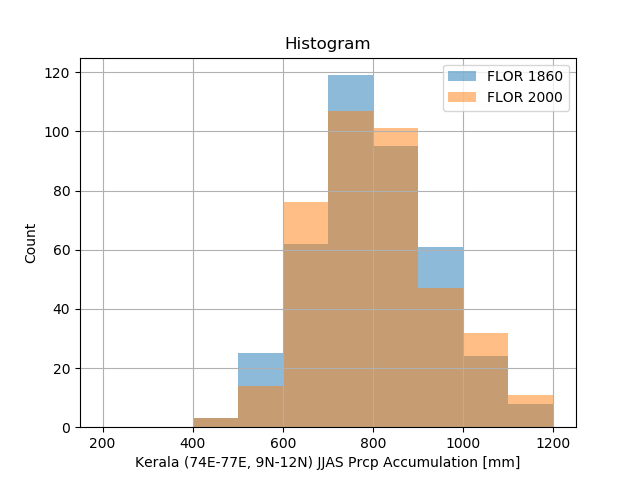

In [11]:
# plot
lon = das['gpcc'].lon
lat = das['gpcc'].lat[-1::-1]
landmask = das['gpcc'].mean('time') \
    .pipe(lambda x: x*0) \
    .pipe(lambda x: x.where(x>=0, other=-1)+1)
bins = range(200,1200+1,100)
year_span = ('0001', '0400')

# 1850
da = das['flor_1860'].sel(time=slice(*year_span)) \
    .interp(lon=lon, lat=lat).where(landmask>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=9)]) \
    .groupby('time.year').sum('time')
da.plot.hist(label='FLOR 1860', alpha=.5, bins=bins)

# 2000
da = das['flor_2000'].sel(time=slice(*year_span)) \
    .interp(lon=lon, lat=lat).where(landmask>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=9)]) \
    .groupby('time.year').sum('time')
da.plot.hist(label='FLOR 2000', alpha=.5, bins=bins)
plt.grid(True)
plt.legend(frameon=True)
(lonmin,lonmax), (latmin,latmax) = box['lon'], box['lat']
plt.xlabel(f'Kerala ({lonmin}E-{lonmax}E, {latmin}N-{latmax}N) JJAS Prcp Accumulation [mm]')

plt.savefig('figs/hist.JJASaccum.flor.pdf')

### FLORish

JJA

<IPython.core.display.Javascript object>


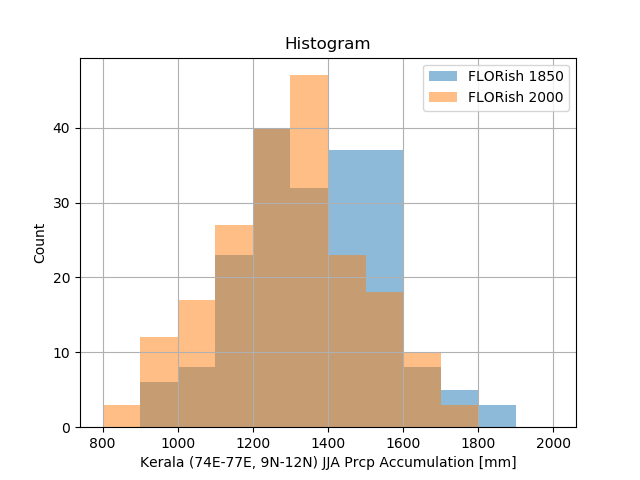

In [227]:
# plot
lon = das['gpcc'].lon
lat = das['gpcc'].lat[-1::-1]
landmask = das['gpcc'].mean('time') \
    .pipe(lambda x: x*0) \
    .pipe(lambda x: x.where(x>=0, other=-1)+1)
bins = range(800,2000+1,100)

# 1850
da = das['florish_1850'].interp(lon=lon, lat=lat).where(landmask>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=8)]) \
    .groupby('time.year').sum('time')
da.plot.hist(label='FLORish 1850', alpha=.5, bins=bins)

# 2000
da = das['florish_2000'].interp(lon=lon, lat=lat).where(landmask>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=8)]) \
    .groupby('time.year').sum('time')
da.plot.hist(label='FLORish 2000', alpha=.5, bins=bins)
plt.grid(True)
plt.legend(frameon=True)
(lonmin,lonmax), (latmin,latmax) = box['lon'], box['lat']
plt.xlabel(f'Kerala ({lonmin}E-{lonmax}E, {latmin}N-{latmax}N) JJA Prcp Accumulation [mm]')

plt.savefig('figs/hist.JJAaccum.florish.pdf')

JJAS

<IPython.core.display.Javascript object>


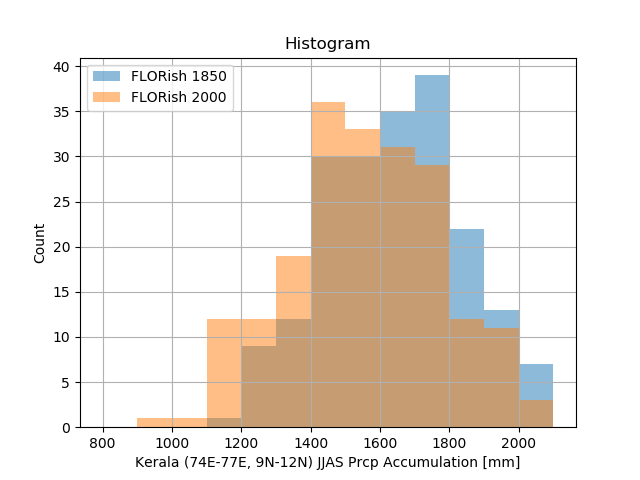

In [18]:
# plot
lon = das['gpcc'].lon
lat = das['gpcc'].lat[-1::-1]
landmask = das['gpcc'].mean('time') \
    .pipe(lambda x: x*0) \
    .pipe(lambda x: x.where(x>=0, other=-1)+1)
bins = range(800,2100+1,100)

# 1850
da = das['florish_1850'].interp(lon=lon, lat=lat).where(landmask>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=9)]) \
    .groupby('time.year').sum('time')
da.plot.hist(label='FLORish 1850', alpha=.5, bins=bins)

# 2000
da = das['florish_2000'].interp(lon=lon, lat=lat).where(landmask>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=9)]) \
    .groupby('time.year').sum('time')
da.plot.hist(label='FLORish 2000', alpha=.5, bins=bins)
plt.grid(True)
plt.legend(frameon=True)
(lonmin,lonmax), (latmin,latmax) = box['lon'], box['lat']
plt.xlabel(f'Kerala ({lonmin}E-{lonmax}E, {latmin}N-{latmax}N) JJAS Prcp Accumulation [mm]')

plt.savefig('figs/hist.JJASaccum.florish.pdf')

## X-day mean

### FLOR

10-day JJA

<IPython.core.display.Javascript object>


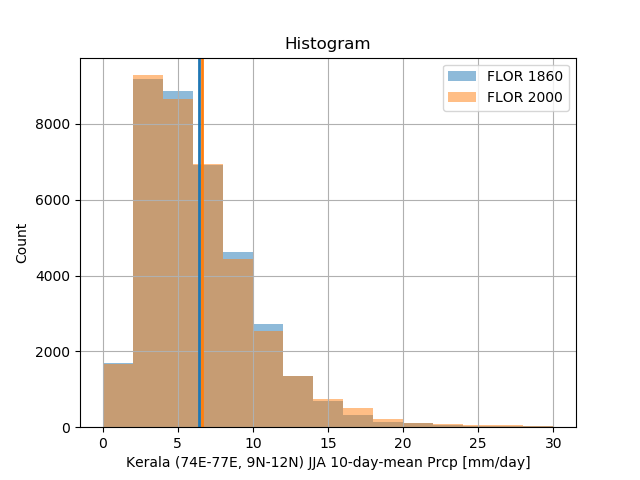

In [228]:
# plot
alpha = .5
bins = np.arange(0,31,2)
year_span = ('0001', '0400')

# 1850
da = das['flor_1860'].sel(time=slice(*year_span)) \
    .interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=8)])
da.plot.hist(label='FLOR 1860', alpha=.5, bins=bins)
plt.axvline(da.mean(), color='C0')

# 1850
da = das['flor_2000'].sel(time=slice(*year_span)) \
    .interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=8)])
da.plot.hist(label='FLOR 2000', alpha=.5, bins=bins)
plt.axvline(da.mean(), color='C1')

# plt.axvline(7, color='k', ls='--')

plt.grid(True)
plt.legend(frameon=True)
(lonmin,lonmax), (latmin,latmax) = box['lon'], box['lat']
plt.xlabel(f'Kerala ({lonmin}E-{lonmax}E, {latmin}N-{latmax}N) JJA 10-day-mean Prcp [mm/day]')

plt.savefig('figs/hist.JJA10dMean.flor.pdf')

7-day JJAS

<IPython.core.display.Javascript object>


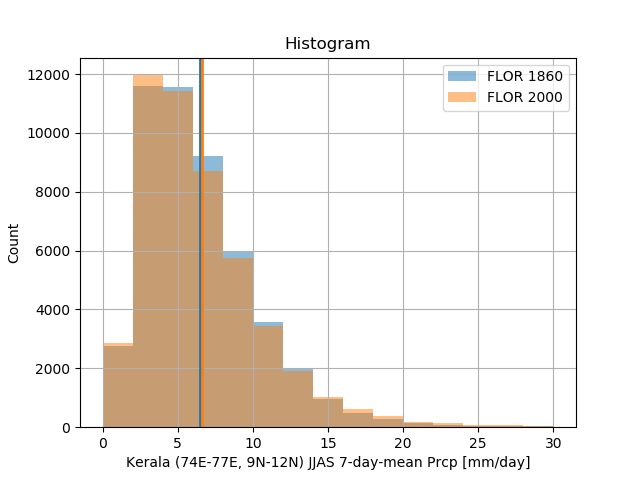

In [20]:
# plot
alpha = .5
bins = np.arange(0,31,2)
year_span = ('0001', '0400')

# 1850
da = das['flor_1860'].sel(time=slice(*year_span)) \
    .interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=7).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=9)])
da.plot.hist(label='FLOR 1860', alpha=.5, bins=bins)
plt.axvline(da.mean(), color='C0')

# 1850
da = das['flor_2000'].sel(time=slice(*year_span)) \
    .interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=7).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=9)])
da.plot.hist(label='FLOR 2000', alpha=.5, bins=bins)
plt.axvline(da.mean(), color='C1')

# plt.axvline(7, color='k', ls='--')

plt.grid(True)
plt.legend(frameon=True)
(lonmin,lonmax), (latmin,latmax) = box['lon'], box['lat']
plt.xlabel(f'Kerala ({lonmin}E-{lonmax}E, {latmin}N-{latmax}N) JJAS 7-day-mean Prcp [mm/day]')

plt.savefig('figs/hist.JJAS7dMean.flor.pdf')

### FLORish

10-day JJA

<IPython.core.display.Javascript object>


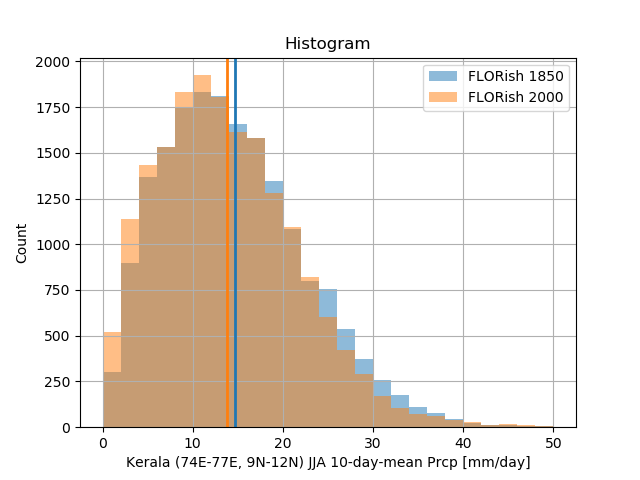

In [229]:
# plot
alpha = .5
bins = np.arange(0,51,2)

# 1850
da = das['florish_1850'].interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=8)])
da.plot.hist(label='FLORish 1850', alpha=.5, bins=bins)
plt.axvline(da.mean(), color='C0')

# 1850
da = das['florish_2000'].interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=8)])
da.plot.hist(label='FLORish 2000', alpha=.5, bins=bins)
plt.axvline(da.mean(), color='C1')

# plt.axvline(7, color='k', ls='--')

plt.grid(True)
plt.legend(frameon=True)
(lonmin,lonmax), (latmin,latmax) = box['lon'], box['lat']
plt.xlabel(f'Kerala ({lonmin}E-{lonmax}E, {latmin}N-{latmax}N) JJA 10-day-mean Prcp [mm/day]')

plt.savefig('figs/hist.JJA10dMean.florish.pdf')

7-day JJAS

<IPython.core.display.Javascript object>


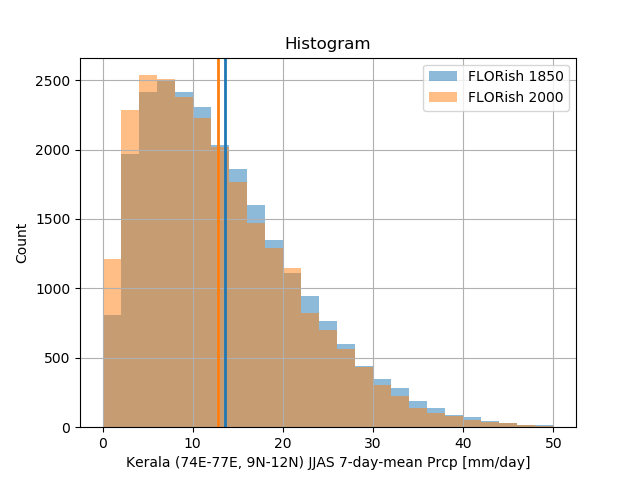

In [21]:
# plot
alpha = .5
bins = np.arange(0,51,2)

# 1850
da = das['florish_1850'].interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=7).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=9)])
da.plot.hist(label='FLORish 1850', alpha=.5, bins=bins)
plt.axvline(da.mean(), color='C0')

# 1850
da = das['florish_2000'].interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=7).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=9)])
da.plot.hist(label='FLORish 2000', alpha=.5, bins=bins)
plt.axvline(da.mean(), color='C1')

# plt.axvline(7, color='k', ls='--')

plt.grid(True)
plt.legend(frameon=True)
(lonmin,lonmax), (latmin,latmax) = box['lon'], box['lat']
plt.xlabel(f'Kerala ({lonmin}E-{lonmax}E, {latmin}N-{latmax}N) JJAS 7-day-mean Prcp [mm/day]')

plt.savefig('figs/hist.JJAS7dMean.florish.pdf')

## X-day mean max

### FLOR

10-day JJA

<IPython.core.display.Javascript object>


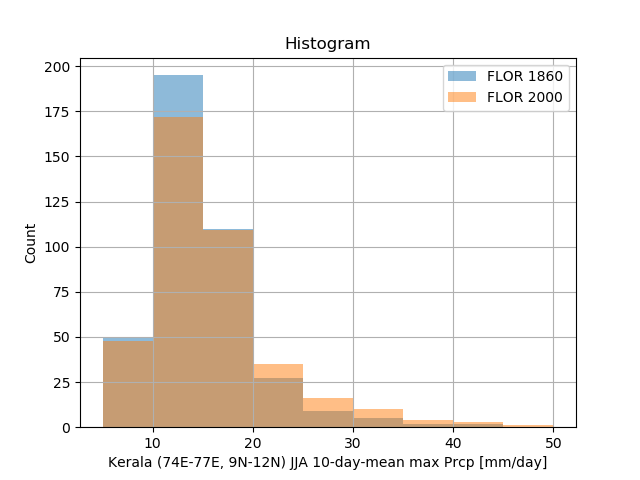

In [230]:
# plot
alpha = .5
bins = np.arange(5,51,5)
year_span = ('0001', '0400')

# 1850
da = das['flor_1860'].sel(time=slice(*year_span)) \
    .interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=8)]) \
    .groupby('time.year').max('time')
da.plot.hist(label='FLOR 1860', alpha=.5, bins=bins)

# 1850
da = das['flor_2000'].sel(time=slice(*year_span)) \
    .interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=8)]) \
    .groupby('time.year').max('time')
da.plot.hist(label='FLOR 2000', alpha=.5, bins=bins)

# plt.axvline(7, color='k', ls='--')

plt.grid(True)
plt.legend(frameon=True)
(lonmin,lonmax), (latmin,latmax) = box['lon'], box['lat']
plt.xlabel(f'Kerala ({lonmin}E-{lonmax}E, {latmin}N-{latmax}N) JJA 10-day-mean max Prcp [mm/day]')

plt.savefig('figs/hist.JJA10dMeanMax.flor.pdf')

7-day JJAS

<IPython.core.display.Javascript object>


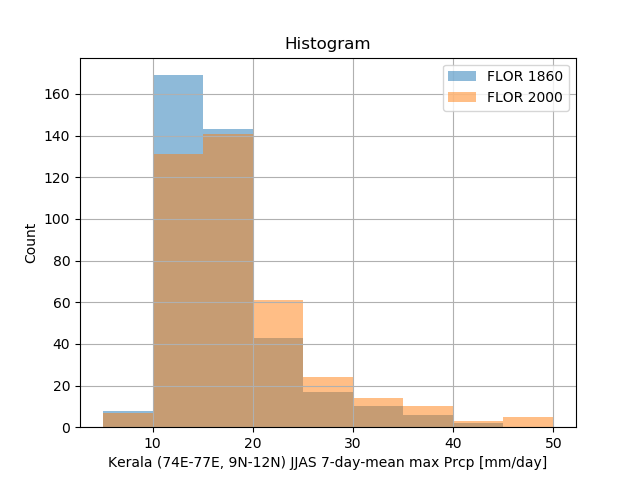

In [22]:
# plot
alpha = .5
bins = np.arange(5,51,5)
year_span = ('0001', '0400')

# 1850
da = das['flor_1860'].sel(time=slice(*year_span)) \
    .interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=7).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=9)]) \
    .groupby('time.year').max('time')
da.plot.hist(label='FLOR 1860', alpha=.5, bins=bins)

# 1850
da = das['flor_2000'].sel(time=slice(*year_span)) \
    .interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=7).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=9)]) \
    .groupby('time.year').max('time')
da.plot.hist(label='FLOR 2000', alpha=.5, bins=bins)

# plt.axvline(7, color='k', ls='--')

plt.grid(True)
plt.legend(frameon=True)
(lonmin,lonmax), (latmin,latmax) = box['lon'], box['lat']
plt.xlabel(f'Kerala ({lonmin}E-{lonmax}E, {latmin}N-{latmax}N) JJAS 7-day-mean max Prcp [mm/day]')

plt.savefig('figs/hist.JJAS7dMeanMax.flor.pdf')

### FLORish

10-day JJA

<IPython.core.display.Javascript object>


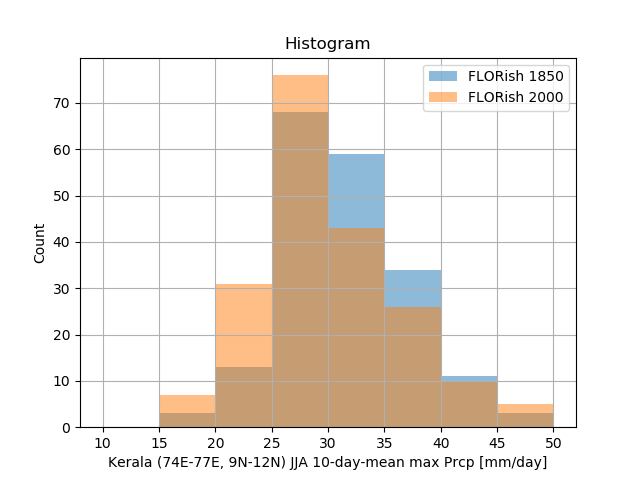

In [231]:
# plot
alpha = .5
bins = np.arange(10,51,5)

# 1850
da = das['florish_1850'].interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=8)]) \
    .groupby('time.year').max('time')
da.plot.hist(label='FLORish 1850', alpha=.5, bins=bins)

# 1850
da = das['florish_2000'].interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=8)]) \
    .groupby('time.year').max('time')
da.plot.hist(label='FLORish 2000', alpha=.5, bins=bins)

# plt.axvline(7, color='k', ls='--')

plt.grid(True)
plt.legend(frameon=True)
(lonmin,lonmax), (latmin,latmax) = box['lon'], box['lat']
plt.xlabel(f'Kerala ({lonmin}E-{lonmax}E, {latmin}N-{latmax}N) JJA 10-day-mean max Prcp [mm/day]')

plt.savefig('figs/hist.JJA10dMeanMax.florish.pdf')

7-day JJAS

<IPython.core.display.Javascript object>


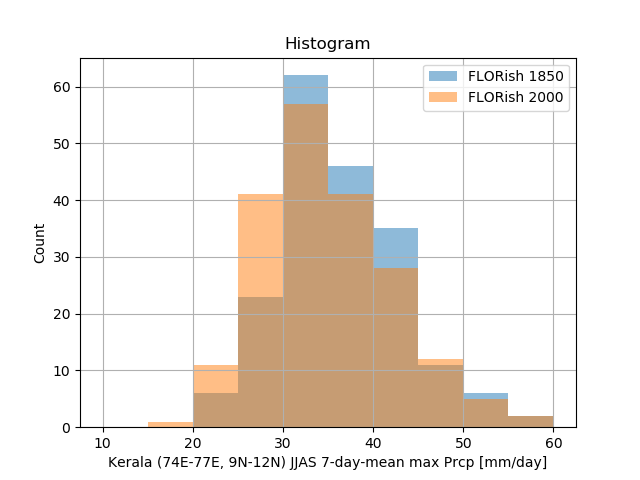

In [24]:
# plot
alpha = .5
bins = np.arange(10,61,5)

# 1850
da = das['florish_1850'].interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=7).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=9)]) \
    .groupby('time.year').max('time')
da.plot.hist(label='FLORish 1850', alpha=.5, bins=bins)

# 1850
da = das['florish_2000'].interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=7).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=9)]) \
    .groupby('time.year').max('time')
da.plot.hist(label='FLORish 2000', alpha=.5, bins=bins)

# plt.axvline(7, color='k', ls='--')

plt.grid(True)
plt.legend(frameon=True)
(lonmin,lonmax), (latmin,latmax) = box['lon'], box['lat']
plt.xlabel(f'Kerala ({lonmin}E-{lonmax}E, {latmin}N-{latmax}N) JJAS 7-day-mean max Prcp [mm/day]')

plt.savefig('figs/hist.JJAS7dMeanMax.florish.pdf')

## Test

<xarray.DataArray (year: 200)>
array([  40.454239,   37.767687,   39.142522,   30.03043 ,   36.143656,
         39.978379,   32.792414,   30.990549,   35.163684,   36.99506 ,
         33.789048,   40.928564,   27.464907,   84.870864,   34.349222,
         25.941028,   28.747609,   37.037992,   32.405069,   44.962576,
         43.934262,   44.042687,   40.289314,   29.495901,   29.035613,
         30.43359 ,   45.054612,   43.026754,   32.2886  ,   44.430349,
         37.331577,   30.777735,   32.754797,   28.348911,   36.01167 ,
         32.528129,   40.220749,   50.637397,   43.899008,   39.380343,
         43.394271,   29.323597,   33.274439,   29.725149,   38.981549,
         29.242541,   46.78893 ,   43.297118,   39.532241,   33.041328,
         50.215691,   35.416048,   27.493169,   30.634671,   36.577264,
         23.437623,   31.065682,   33.921272,   32.223831,   41.444514,
         33.694713,   46.107829,   39.566046,   42.047948,   55.072435,
         33.470102,   30.848228, 

<IPython.core.display.Javascript object>


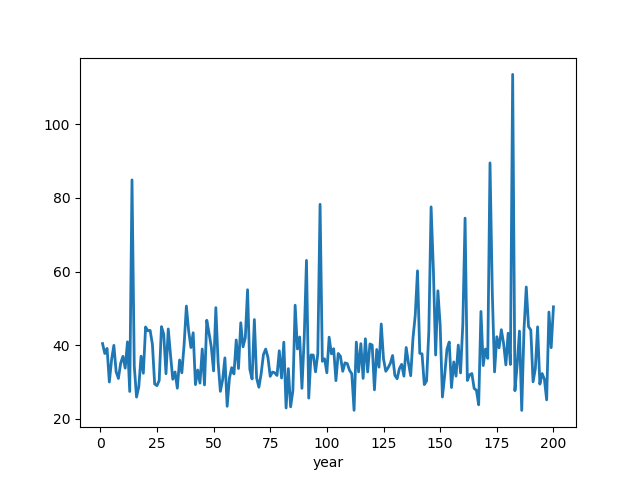

In [26]:
da = das['florish_1850'].interp(lon=lonc, lat=latc).where(landmaskc>.5) \
    .sel(lon=slice(*box['lon']), lat=slice(*box['lat'])).geo.fldmean() \
    .rolling(time=7).mean() \
    .pipe(lambda x: x[(x['time.month']>=6) & (x['time.month']<=9)]) \
    .groupby('time.year').max('time')
print(da)
da.plot()

In [27]:
model = ske.models.classic.GEV(da.values, fit_method='mle', ci=0.05, ci_method='delta', return_periods=[100,130])

//home/wenchang/wython/skextremes/models/classic.py:527: RuntimeWarning: divide by zero encountered in log
  sT = -_np.log(1.-self.frec/T)
//home/wenchang/wython/skextremes/models/classic.py:527: RuntimeWarning: invalid value encountered in log
  sT = -_np.log(1.-self.frec/T)
//home/wenchang/wython/skextremes/models/classic.py:502: RuntimeWarning: invalid value encountered in log
  (1. + 1. / c) * _np.sum(_np.log(expr)) +
//home/wenchang/wython/skextremes/models/classic.py:503: RuntimeWarning: invalid value encountered in power
  _np.sum(expr ** (-1. / c)))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/numdifftools/limit

In [28]:
print(model.params)
print(model.return_values)
print(model.return_periods)

OrderedDict([('shape', -0.1127651620444251), ('location', 33.400991927087766), ('scale', 6.7308595603885282)])
[ 73.98389357  77.0083576 ]
[100 130]


<IPython.core.display.Javascript object>


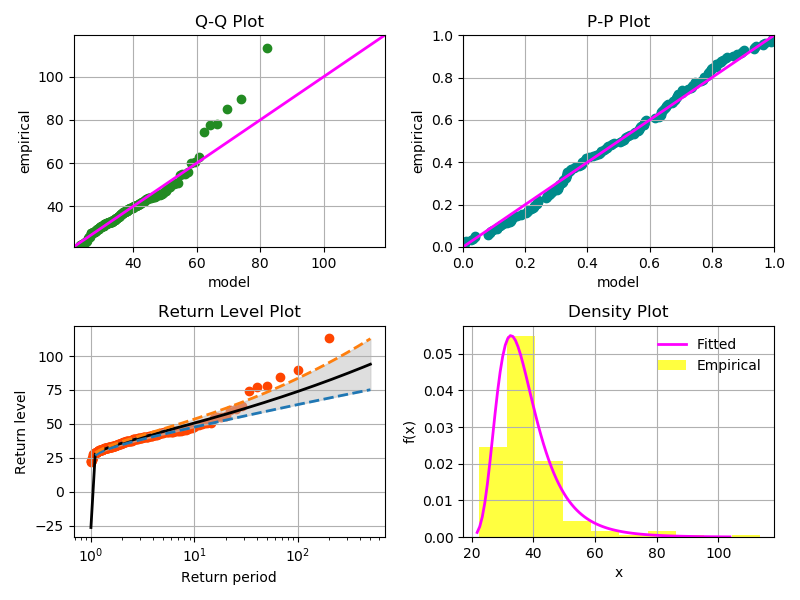

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(<Figure size 800x600 with 4 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b6d573bd128>)

In [29]:
model.plot_summary()

In [25]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js">
</script>